In [2]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [3]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt 

torch.__version__

'2.1.2+cu121'

## 1. Data (Preparing and loading)
 Data can be almost anything... in machine learning
 <ul>
 <li>Excel spreadsheet</li>
 <li>Images of any kind</li>
 <li>Videos (Youtube has lots of data...)</li>
 <li>Audio like songs or podcasts</li>
 <li>DNA</li>
 <li>Text</li>
 </ul>

 Machine learning is a game of two parts:

 <ol>
 <li>Get data into a numerical representation</li>
 <li>Build a model to learn patterns in that numerical representation</li>
 </ol>

 we'll use a linear regression formula(y=a+mx) to make a straight line with known parameters.

In [4]:
#creating known parameters
weight = 0.7
bias = 0.3  

#Create
start = 0
end = 1
step = 0.02
X = torch.arange(start=start,end=end,step=step)
print(f"shape of X before : {X.shape}")
X = X.unsqueeze(dim=1) # capital x shows that this indicates to tensor
print(f"after unsqueezing : {X.shape}")
#
#after unsqueezing : [1,len(X)]
y = weight*X + bias # follows linear regression y = mx + b

print(X[:10])
print(y[:10])

shape of X before : torch.Size([50])
after unsqueezing : torch.Size([50, 1])
tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [5]:
#here y is label for each X
len(X),len(y)

(50, 50)

### Spliting data into training and test sets (one of the most important concept in machine learning in general)

#### Let's create a training and test set with out data

In [6]:
split_train = int(0.8*len(X))

X_train = X[:split_train]
X_test = X[split_train:len(X)]

y_train = y[:split_train]
y_test = y[split_train:len(y)]

len(X_train),len(X_test),len(y_train),len(y_test)

(40, 10, 40, 10)

### Visualize the data

In [24]:
def plot_prediction(train_data=X_train,
                    train_labels = y_train,
                    test_data = X_test,
                    test_labels = y_test,
                    pridictions = None):
    """ 
    Plots training data, test data and compares predictions.
    """
    #define the size of the chart
    plt.figure(figsize=(5,5))

    #plot training data in blue
    plt.scatter(train_data,train_labels,c="b",s=5,label="training data")

    #plot test data in green
    plt.scatter(test_data,test_labels,c="g",s=15,label="training data")

    if pridictions is not None:
        #plot the predictions as well
        plt.scatter(test_data,pridictions,c="r",s=5,label="predictions")

    #show the lagend
    plt.legend(loc="upper left")
        
    
    

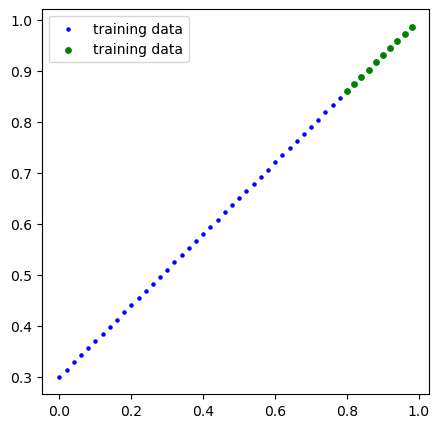

In [8]:
plot_prediction() # blue dots are ideal output

## Build Model

first PyTorch model!

What out model does:
<ul>
<li>Start with random values ( weights and bias )</li>
<li>Look at training data and adjust the random values to better represent ( or get closer to ) the ideal values (the weights and bias values we used to create the data)</li>
</ul>

How does it do so?

Through two main algorithms:
<ol>
<li>Gradient descent</li>
<li>Backpropagation</li>
</ol>


In [15]:
from torch import nn

#create linear regression model class
#every model in pytorch inherit from nn.module that's why you need to define forward method for overriding purpose


class LinearRegressionModel(nn.Module): # almost everything in pytorch inherits from nn.Module
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weight and try to adjust it to the ideal weight
                                                requires_grad=True, # <- can this parameter be updated via gradient descent?
                                                dtype=torch.float)) # <- PyTorch loves the datatype torch.float32
        
        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias and try to adjust it to the ideal bias
                                             requires_grad=True, # <- can this parameter be updated via gradient descent?
                                             dtype=torch.float)) # <- PyTorch loves the datatype torch.float32
        
        #Forward method to define the computation in the model 
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x is input data
        return self.weights*x + self.bias # this is the linear regression formula

### PyTorch model building essentials

<ul>
<li><b>torch.nn</b> - contains all of the buildings for computational graphs ( a neural network can be considered a computational graph )</li>
<li><b>torch.nn.Parameter</b> - what parameters should out model try and learn, often a  PyTorch layer from torch.nn will set these for us</li>
<li><b>torch.nn.Module</b> - The base class for all neural network modules, if you subclass it, you should overwrite forward()</li>
<li><b>torch.optim</b> - where the optimizers in PyTorch live, they will help with gradient descent</li>
<li><b>def forward()</b> - All nn Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation</li>
</ul>

### Checking the contents of our PyTorch model

we have created the model, let's see what's inside...
So we can check our model parameters or what's inside out model using .parameters()

In [17]:
#Create a random seed
torch.manual_seed(42)

#create an instance of the model ( this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

#check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [18]:
#listing named parameters
model_0.state_dict()
# model_0.weights, model_0.bias

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [19]:
#listing known parameters
weight,bias

(0.7, 0.3)

Here the task is to take the value of named params to near to known params, the closer we get the values the better we will able to predict data in model

### Make predictions using <code>torch.inference_mode()</code>
To check our model's predictive power, let's see how well it predicts <code>y_test</code> based on <code>x_test</code>
When we pass data through our model, it's going to run it through the <code>forward()</code> method.

In [23]:
# make predictions using model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds,y_test

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

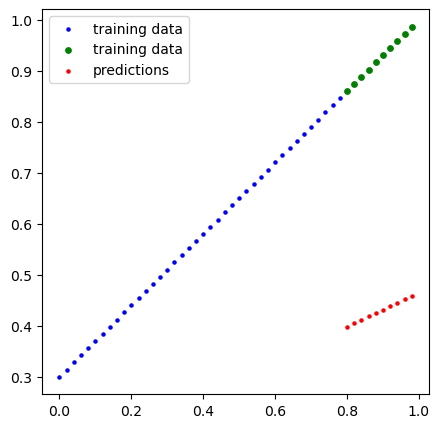

In [25]:
plot_prediction(pridictions=y_preds) 

## Training this model

The whole idea of training is for a model to move from some <i>unknown</i> parameters (these may be random) to some <i>known</i> parameters.

or in other words from a poor representation of the data to a bettere representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

<b>Note:</b> Loss function may also be called cost function or criterion in defferent areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

<b>Loss function: </b> A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
<b>Optimizer: </b> Takes into account the loss of a model and adjusts the model's parameters (w and b in our case) to improve the loss function.

And specifically for PyTorch, we need:
1. A training loop
2. A testing loop